
#Assignment 6: Apply NB



<ol>
    <li>Minimum data points need to be considered for people having 4GB RAM is <strong>50k</strong> and for 8GB RAM is <strong>100k</strong></li>
    <li>When you are using ramdomsearchcv or gridsearchcv you need not split the data into X_train,X_cv,X_test. As the above methods use kfold. The model will learn better if train data is more so splitting to X_train,X_test will suffice.</li>
    <li>If you are writing for loops to tune your model then you need split the data into X_train,X_cv,X_test.</li>
    <li>While splitting the data explore stratify parameter. </li>
    <li><strong>Apply Multinomial NB on these feature sets</strong></li>
        <ul>
            <li>Features that need to be considered</li> 
                <dl>
                  <dt>essay</dt>
                    <dd>while encoding essay, try to experiment with the max_features and n_grams parameter of vectorizers and see if it increases AUC score.</dd>
                  <dt>categorical features</dt>
                  <dd> - teacher_prefix</dd>
                  <dd> - project_grade_category</dd>
                  <dd> - school_state</dd>
                  <dd> - clean_categories</dd>
                  <dd> - clean_subcategories</dd>
                  <dt>numerical features</dt>
                  <dd> - price</dd>
                  <dd> - teacher_number_of_previously_posted_projects</dd>
                  <dd>while encoding the numerical features check <a href='https://imgur.com/ldZA1zg'>this</a> and <a href='https://ac-classroom-production.s3.amazonaws.com/public/COMMENT/Annotation_2020-05-21_225912_0lyZzN8.jpg'>this</a></dd>
                </dl>    
            <li><font color='red'>Set 1</font>: categorical, numerical features + preprocessed_eassay (BOW)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features + preprocessed_eassay (TFIDF)</li>
        </ul>
    <li><strong>The hyper paramter tuning(find best alpha:smoothing parameter)</strong>
        <ul>
    <li>Consider alpha values in range: 10^-5 to 10^2 like [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]</li>
    <li>Explore class_prior = [0.5, 0.5] parameter which can be present in MultinomialNB function(go through <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>this</a> ) then check how results might change.
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>For hyper parameter tuning using k-fold cross validation(use GridsearchCV or RandomsearchCV)/simple cross validation data (write for loop to iterate over hyper parameter values)</li>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/hUv6aEy.jpg' width=300px><dd>-while plotting take log(alpha) on your X-axis so that it will be more readable</dd></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://imgur.com/q2P65L5.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
        <img src='https://i.imgur.com/IdN5Ctv.png' width=300px><dd>-plot the confusion matrix in heatmaps, while plotting the confusion matrix go through the <a href='https://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor'>link </a>
</dd></li>
        </ul>
<li>find the top 20 features from either from feature <font color='red'>Set 1</font> or feature <font color='red'>Set 2</font> using values of `feature_log_prob_ ` parameter of `MultinomialNB` 
(https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) and print <strong>BOTH</strong> positive as well as negative corresponding feature names. <dd> - go through the <a href='https://imgur.com/mWvE7gj'>link </a> </dd>
    </li>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

In [435]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/

from nltk.corpus import stopwords
import pickle

from tqdm import tqdm
import os

#1. Reading Data

In [436]:
project_data = pd.read_csv('/content/drive/MyDrive/donors dataset/train_data.csv', nrows=50000)
resource_data = pd.read_csv('/content/drive/MyDrive/donors dataset/resources.csv')

In [437]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)

Number of data points in train data (50000, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


#2. Preprocessing Categorical Features: project_grade_category

In [438]:
project_data['project_grade_category'].value_counts()

Grades PreK-2    20316
Grades 3-5       16968
Grades 6-8        7750
Grades 9-12       4966
Name: project_grade_category, dtype: int64

In [439]:
# https://stackoverflow.com/questions/36383821/pandas-dataframe-apply-function-to-column-strings-based-on-other-column-value
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace(' ','_')
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace('-','_')
project_data['project_grade_category'] = project_data['project_grade_category'].str.lower()
project_data['project_grade_category'].value_counts()

grades_prek_2    20316
grades_3_5       16968
grades_6_8        7750
grades_9_12       4966
Name: project_grade_category, dtype: int64

#3. Preprocessing Categorical Features: project_subject_categories

In [440]:
project_data['project_subject_categories'].value_counts()

Literacy & Language                           10927
Math & Science                                 7695
Literacy & Language, Math & Science            6705
Health & Sports                                4700
Music & The Arts                               2358
Special Needs                                  1913
Literacy & Language, Special Needs             1814
Applied Learning                               1719
Math & Science, Literacy & Language            1041
Applied Learning, Literacy & Language          1018
Math & Science, Special Needs                   871
History & Civics                                839
Literacy & Language, Music & The Arts           794
Math & Science, Music & The Arts                755
Applied Learning, Special Needs                 672
History & Civics, Literacy & Language           651
Health & Sports, Special Needs                  633
Warmth, Care & Hunger                           606
Math & Science, Applied Learning                565
Applied Lear

remove spaces, 'the'
replace '&' with '_', and ',' with '_'

In [441]:
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace(' The ','')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace(' ','')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace('&','_')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace(',','_')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.lower()
project_data['project_subject_categories'].value_counts()

literacy_language                       10927
math_science                             7695
literacy_language_math_science           6705
health_sports                            4700
music_arts                               2358
specialneeds                             1913
literacy_language_specialneeds           1814
appliedlearning                          1719
math_science_literacy_language           1041
appliedlearning_literacy_language        1018
math_science_specialneeds                 871
history_civics                            839
literacy_language_music_arts              794
math_science_music_arts                   755
appliedlearning_specialneeds              672
history_civics_literacy_language          651
health_sports_specialneeds                633
warmth_care_hunger                        606
math_science_appliedlearning              565
appliedlearning_math_science              477
health_sports_literacy_language           369
literacy_language_history_civics  

#4. Preprocessing Categorical Features: teacher_prefix

In [442]:
project_data['teacher_prefix'].value_counts()

Mrs.       26140
Ms.        17936
Mr.         4859
Teacher     1061
Dr.            2
Name: teacher_prefix, dtype: int64

In [443]:
# check if we have any nan values are there
print(project_data['teacher_prefix'].isnull().values.any())
print("number of nan values",project_data['teacher_prefix'].isnull().values.sum())

True
number of nan values 2


numebr of missing values are very less in number, we can replace it with Mrs. as most of the projects are submitted by Mrs.

In [444]:
project_data['teacher_prefix']=project_data['teacher_prefix'].fillna('Mrs.')

In [445]:
project_data['teacher_prefix'].value_counts()

Mrs.       26142
Ms.        17936
Mr.         4859
Teacher     1061
Dr.            2
Name: teacher_prefix, dtype: int64

Remove '.'
convert all the chars to small

In [446]:
project_data['teacher_prefix'] = project_data['teacher_prefix'].str.replace('.','')
project_data['teacher_prefix'] = project_data['teacher_prefix'].str.lower()
project_data['teacher_prefix'].value_counts()

mrs        26142
ms         17936
mr          4859
teacher     1061
dr             2
Name: teacher_prefix, dtype: int64

#5. Preprocessing Categorical Features: project_subject_subcategories

In [447]:
project_data['project_subject_subcategories'].value_counts()

Literacy                                   4434
Literacy, Mathematics                      3833
Literature & Writing, Mathematics          2705
Literacy, Literature & Writing             2570
Mathematics                                2441
                                           ... 
Applied Sciences, Warmth, Care & Hunger       1
Community Service, Financial Literacy         1
Visual Arts, Warmth, Care & Hunger            1
Financial Literacy, Foreign Languages         1
Foreign Languages, Performing Arts            1
Name: project_subject_subcategories, Length: 384, dtype: int64

In [448]:
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace(' The ','')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace(' ','')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace('&','_')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace(',','_')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.lower()
project_data['project_subject_subcategories'].value_counts()

literacy                                 4434
literacy_mathematics                     3833
literature_writing_mathematics           2705
literacy_literature_writing              2570
mathematics                              2441
                                         ... 
college_careerprep_teamsports               1
charactereducation_nutritioneducation       1
visualarts_warmth_care_hunger               1
civics_government_extracurricular           1
economics_music                             1
Name: project_subject_subcategories, Length: 384, dtype: int64

#6. Preprocessing Categorical Features: school_state

In [449]:
project_data['school_state'].value_counts()

CA    7024
NY    3393
TX    3320
FL    2839
NC    2340
IL    1967
SC    1830
GA    1828
MI    1468
PA    1419
OH    1180
IN    1171
MO    1166
WA    1103
LA    1094
MA    1076
OK    1074
NJ    1005
AZ     994
VA     916
WI     833
UT     792
AL     790
TN     774
CT     774
MD     668
NV     665
KY     614
MS     598
OR     577
MN     556
CO     538
AR     446
IA     306
ID     302
KS     285
DC     247
HI     239
NM     236
ME     222
WV     218
DE     155
AK     153
NE     144
SD     142
NH     141
RI     126
MT     106
ND      63
WY      51
VT      32
Name: school_state, dtype: int64

convert all of them into small letters

In [450]:
project_data['school_state'] = project_data['school_state'].str.lower()
project_data['school_state'].value_counts()

ca    7024
ny    3393
tx    3320
fl    2839
nc    2340
il    1967
sc    1830
ga    1828
mi    1468
pa    1419
oh    1180
in    1171
mo    1166
wa    1103
la    1094
ma    1076
ok    1074
nj    1005
az     994
va     916
wi     833
ut     792
al     790
ct     774
tn     774
md     668
nv     665
ky     614
ms     598
or     577
mn     556
co     538
ar     446
ia     306
id     302
ks     285
dc     247
hi     239
nm     236
me     222
wv     218
de     155
ak     153
ne     144
sd     142
nh     141
ri     126
mt     106
nd      63
wy      51
vt      32
Name: school_state, dtype: int64

#7. Preprocessing Categorical Features: essay

In [451]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [452]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [453]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [454]:
print("printing some random essay")
print(9, project_data['essay'].values[9])
print('-'*50)
print(34, project_data['essay'].values[34])
print('-'*50)
print(147, project_data['essay'].values[147])

printing some random essay
9 Over 95% of my students are on free or reduced lunch.  I have a few who are homeless, but despite that, they come to school with an eagerness to learn.  My students are inquisitive eager learners who  embrace the challenge of not having great books and other resources  every day.  Many of them are not afforded the opportunity to engage with these big colorful pages of a book on a regular basis at home and they don't travel to the public library.  \r\nIt is my duty as a teacher to do all I can to provide each student an opportunity to succeed in every aspect of life. \r\nReading is Fundamental! My students will read these books over and over again while boosting their comprehension skills. These books will be used for read alouds, partner reading and for Independent reading. \r\nThey will engage in reading to build their \"Love for Reading\" by reading for pure enjoyment. They will be introduced to some new authors as well as some old favorites. I want my st

In [455]:
# Combining all the above stundents 
from tqdm import tqdm
def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentance in tqdm(text_data):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

In [456]:
preprocessed_essays = preprocess_text(project_data['essay'].values)

100%|██████████| 50000/50000 [00:31<00:00, 1590.02it/s]


#8. Preprocessing Numerical Values: price

In [457]:
# https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head(2)

,id,price,quantity
0,p000001,459.56,7
1,p000002,515.89,21


In [458]:
# join two dataframes in python: 
project_data = pd.merge(project_data, price_data, on='id', how='left')

In [459]:
project_data['price'].head()

0    154.60
1    299.00
2    516.85
3    232.90
4     67.98
Name: price, dtype: float64

#8.1 applying StandardScaler

In [460]:
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#scaler.fit(project_data['price'].values.reshape(-1, 1))
#project_data['std_price']=scaler.transform(project_data['price'].values.reshape(-1, 1) )

In [461]:
#project_data['std_price'].head()

In [462]:
#project_data['price']=project_data['std_price']

In [463]:
#project_data.head(1)

#9. Preprocessing Numerical Values: teacher_number_of_previously_posted_projects

In [464]:
project_data['teacher_number_of_previously_posted_projects']

0         0
1         7
2         1
3         4
4         1
         ..
49995     8
49996     6
49997     9
49998    37
49999     0
Name: teacher_number_of_previously_posted_projects, Length: 50000, dtype: int64

#9.1 applying StandardScaler

In [465]:
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#scaler.fit(project_data['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
#project_data['teacher_number_of_previously_posted_projects']=scaler.transform(project_data['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1) )

In [466]:
#project_data['teacher_number_of_previously_posted_projects'].head(2)

In [467]:
preprocessed_data=project_data

#1.1 Loading Data

In [469]:
data =preprocessed_data

In [470]:
y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis=1)
X.head(1)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,essay,price,quantity
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,mrs,in,2016-12-05 13:43:57,grades_prek_2,literacy_language,esl_literacy,Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,My students are English learners that are work...,154.6,23


#1.2 Splitting data into Train and cross validation(or test): Stratified Sampling

In [471]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

##1.3 Make Data Model Ready: encoding eassay

In [472]:
ex = ["classroom students should take break",
"low income homes students receive free breakfast",
"students will receive low grades"]
vectorizer = CountVectorizer()
vectorizer.fit(ex)
print(vectorizer.transform(ex).toarray())
print(vectorizer.get_feature_names())

[[1 0 1 0 0 0 0 0 0 1 1 1 0]
 [0 1 0 1 0 1 1 1 1 0 1 0 0]
 [0 0 0 0 1 0 0 1 1 0 1 0 1]]
['break', 'breakfast', 'classroom', 'free', 'grades', 'homes', 'income', 'low', 'receive', 'should', 'students', 'take', 'will']


In [473]:
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)


vectorizer_bow_essay = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer_bow_essay.fit(X_train['essay'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_bow = vectorizer_bow_essay.transform(X_train['essay'].values)
X_cv_essay_bow = vectorizer_bow_essay.transform(X_cv['essay'].values)
X_test_essay_bow = vectorizer_bow_essay.transform(X_test['essay'].values)

print("After vectorizations")
print(X_train_essay_bow.shape, y_train.shape)
print(X_cv_essay_bow.shape, y_cv.shape)
print(X_test_essay_bow.shape, y_test.shape)
print("="*100)


# print("YOU SHOULD NOT DO SOMETHING LIKE THIS")
# vectorizer = CountVectorizer()
# x_train_bow = vectorizer.fit_transform(X_train['essay'].values)
# x_cv_bow = vectorizer.fit_transform(X_cv['essay'].values)
# x_test_bow = vectorizer.fit_transform(X_test['essay'].values)

# print(x_train_bow.shape, y_train.shape)
# print(x_cv_bow.shape, y_cv.shape)
# print(x_test_bow.shape, y_test.shape)

print("NOTE: THE NUMBER OF COLUMNS IN EACH OF THE VECTOR WONT BE SAME")

(22445, 19) (22445,)
(11055, 19) (11055,)
(16500, 19) (16500,)
After vectorizations
(22445, 5000) (22445,)
(11055, 5000) (11055,)
(16500, 5000) (16500,)
NOTE: THE NUMBER OF COLUMNS IN EACH OF THE VECTOR WONT BE SAME


In [474]:
#Converting essay in to TFIDF representation using count vectorizer.
vectorizer_tfidf_essay = TfidfVectorizer(min_df=10)
vectorizer_tfidf_essay.fit(X_train['essay'])      #Fitting has to be on Train data
 
X_train_essay_tfidf = vectorizer_tfidf_essay.transform(X_train['essay'].values)
X_cv_essay_tfidf = vectorizer_tfidf_essay.transform(X_cv['essay'].values)
X_test_essay_tfidf = vectorizer_tfidf_essay.transform(X_test['essay'].values)

print("Shape of train data matrix after tfidf ",X_train_essay_tfidf.shape)
print("Shape of train data matrix after tfidf ",X_cv_essay_tfidf.shape)
print("Shape of test data matrix after tfidf ",X_test_essay_tfidf.shape)

Shape of train data matrix after tfidf  (22445, 9136)
Shape of train data matrix after tfidf  (11055, 9136)
Shape of test data matrix after tfidf  (16500, 9136)


#1.4 Make Data Model Ready: encoding numerical, categorical features


categorical features
- teacher_prefix
- project_grade_category
- school_state
- clean_categories
- clean_subcategories

1.4.1 encoding categorical features: School State

In [475]:
vectorizer1 = CountVectorizer(binary=True)
vectorizer1.fit(X_train['school_state'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_state_ohe = vectorizer1.transform(X_train['school_state'].values)
X_cv_state_ohe = vectorizer1.transform(X_cv['school_state'].values)
X_test_state_ohe = vectorizer1.transform(X_test['school_state'].values)

print("After vectorizations")
print(X_train_state_ohe.shape, y_train.shape)
print(X_cv_state_ohe.shape, y_cv.shape)
print(X_test_state_ohe.shape, y_test.shape)
print(vectorizer1.get_feature_names())
print("="*100)

After vectorizations
(22445, 51) (22445,)
(11055, 51) (11055,)
(16500, 51) (16500,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


1.4.2 encoding categorical features: teacher_prefix

In [476]:
vectorizer2 = CountVectorizer(binary=True)
vectorizer2.fit(X_train['teacher_prefix'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_teacher_ohe = vectorizer2.transform(X_train['teacher_prefix'].values)
X_cv_teacher_ohe = vectorizer2.transform(X_cv['teacher_prefix'].values)
X_test_teacher_ohe = vectorizer2.transform(X_test['teacher_prefix'].values)

print("After vectorizations")
print(X_train_teacher_ohe.shape, y_train.shape)
print(X_cv_teacher_ohe.shape, y_cv.shape)
print(X_test_teacher_ohe.shape, y_test.shape)
print(vectorizer2.get_feature_names())
print("="*100)

After vectorizations
(22445, 4) (22445,)
(11055, 4) (11055,)
(16500, 4) (16500,)
['mr', 'mrs', 'ms', 'teacher']


1.4.3 encoding categorical features: project_grade_category

In [477]:
vectorizer3 = CountVectorizer(binary=True)
vectorizer3.fit(X_train['project_grade_category'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_grade_ohe = vectorizer3.transform(X_train['project_grade_category'].values)
X_cv_grade_ohe = vectorizer3.transform(X_cv['project_grade_category'].values)
X_test_grade_ohe = vectorizer3.transform(X_test['project_grade_category'].values)

print("After vectorizations")
print(X_train_grade_ohe.shape, y_train.shape)
print(X_cv_grade_ohe.shape, y_cv.shape)
print(X_test_grade_ohe.shape, y_test.shape)
print(vectorizer3.get_feature_names())
print("="*100)

After vectorizations
(22445, 4) (22445,)
(11055, 4) (11055,)
(16500, 4) (16500,)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']


1.4.4 encoding categorical features: clean_categories


clean_categories

In [478]:
vectorizer4 = CountVectorizer(binary=True)
vectorizer4.fit(X_train['project_subject_categories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_project_subject_categories_ohe = vectorizer4.transform(X_train['project_subject_categories'].values)
X_cv_project_subject_categories_ohe = vectorizer4.transform(X_cv['project_subject_categories'].values)
X_test_project_subject_categories_ohe = vectorizer4.transform(X_test['project_subject_categories'].values)

print("After vectorizations")
print(X_train_project_subject_categories_ohe.shape, y_train.shape)
print(X_cv_project_subject_categories_ohe.shape, y_cv.shape)
print(X_test_project_subject_categories_ohe.shape, y_test.shape)
print(vectorizer4.get_feature_names())
print("="*100)

After vectorizations
(22445, 49) (22445,)
(11055, 49) (11055,)
(16500, 49) (16500,)
['appliedlearning', 'appliedlearning_health_sports', 'appliedlearning_history_civics', 'appliedlearning_literacy_language', 'appliedlearning_math_science', 'appliedlearning_music_arts', 'appliedlearning_specialneeds', 'appliedlearning_warmth_care_hunger', 'health_sports', 'health_sports_appliedlearning', 'health_sports_history_civics', 'health_sports_literacy_language', 'health_sports_math_science', 'health_sports_music_arts', 'health_sports_specialneeds', 'health_sports_warmth_care_hunger', 'history_civics', 'history_civics_appliedlearning', 'history_civics_health_sports', 'history_civics_literacy_language', 'history_civics_math_science', 'history_civics_music_arts', 'history_civics_specialneeds', 'literacy_language', 'literacy_language_appliedlearning', 'literacy_language_health_sports', 'literacy_language_history_civics', 'literacy_language_math_science', 'literacy_language_music_arts', 'literacy_lan

1.4.5 encoding categorical features: clean_categories

#clean subcategories

In [479]:
vectorizer5 = CountVectorizer(binary=True)
vectorizer5.fit(X_train['project_subject_subcategories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_project_subject_subcategories_ohe = vectorizer5.transform(X_train['project_subject_subcategories'].values)
X_cv_project_subject_subcategories_ohe = vectorizer5.transform(X_cv['project_subject_subcategories'].values)
X_test_project_subject_subcategories_ohe = vectorizer5.transform(X_test['project_subject_subcategories'].values)

print("After vectorizations")
print(X_train_project_subject_subcategories_ohe.shape, y_train.shape)
print(X_cv_project_subject_subcategories_ohe.shape, y_cv.shape)
print(X_test_project_subject_subcategories_ohe.shape, y_test.shape)
print(vectorizer5.get_feature_names())
print("="*100)

After vectorizations
(22445, 342) (22445,)
(11055, 342) (11055,)
(16500, 342) (16500,)
['appliedsciences', 'appliedsciences_charactereducation', 'appliedsciences_civics_government', 'appliedsciences_college_careerprep', 'appliedsciences_communityservice', 'appliedsciences_earlydevelopment', 'appliedsciences_economics', 'appliedsciences_environmentalscience', 'appliedsciences_esl', 'appliedsciences_extracurricular', 'appliedsciences_gym_fitness', 'appliedsciences_health_lifescience', 'appliedsciences_health_wellness', 'appliedsciences_history_geography', 'appliedsciences_literacy', 'appliedsciences_literature_writing', 'appliedsciences_mathematics', 'appliedsciences_music', 'appliedsciences_nutritioneducation', 'appliedsciences_other', 'appliedsciences_parentinvolvement', 'appliedsciences_performingarts', 'appliedsciences_socialsciences', 'appliedsciences_specialneeds', 'appliedsciences_teamsports', 'appliedsciences_visualarts', 'charactereducation', 'charactereducation_civics_governmen

#1.4.6 encoding numerical features: Price

In [480]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_train['price'].values.reshape(-1,1))

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(-1,1))
X_cv_price_norm = normalizer.transform(X_cv['price'].values.reshape(-1,1))
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(-1,1))



print("After vectorizations")
print(X_train_price_norm.shape, y_train.shape)
print(X_cv_price_norm.shape, y_cv.shape)
print(X_test_price_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(22445, 1) (22445,)
(11055, 1) (11055,)
(16500, 1) (16500,)


1.4.7 encoding numerical features: number_of_previously_posted_projects




In [481]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

X_train_teacher_number_of_previously_posted_projects_norm = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_cv_teacher_number_of_previously_posted_projects_norm = normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_teacher_number_of_previously_posted_projects_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))



print("After vectorizations")
print(X_train_teacher_number_of_previously_posted_projects_norm.shape, y_train.shape)
print(X_cv_teacher_number_of_previously_posted_projects_norm.shape, y_cv.shape)
print(X_test_teacher_number_of_previously_posted_projects_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(22445, 1) (22445,)
(11055, 1) (11055,)
(16500, 1) (16500,)


#1.4.8 Concatinating all the features

##set1

In [482]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((X_train_essay_bow, X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe, X_train_price_norm,
               X_train_project_subject_categories_ohe,X_train_project_subject_subcategories_ohe,
               X_train_teacher_number_of_previously_posted_projects_norm)).tocsr()
X_cr = hstack((X_cv_essay_bow, X_cv_state_ohe, X_cv_teacher_ohe, X_cv_grade_ohe, X_cv_price_norm,
               X_cv_project_subject_categories_ohe,X_cv_project_subject_subcategories_ohe,
               X_cv_teacher_number_of_previously_posted_projects_norm)).tocsr()
X_te = hstack((X_test_essay_bow, X_test_state_ohe, X_test_teacher_ohe, X_test_grade_ohe, X_test_price_norm,
               X_test_project_subject_categories_ohe,X_test_project_subject_subcategories_ohe,
               X_test_teacher_number_of_previously_posted_projects_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(22445, 5452) (22445,)
(11055, 5452) (11055,)
(16500, 5452) (16500,)


#1.5 Appling NB on different kind of featurization as mentioned in the instructions

1.5.1 Appling : BOW featurization

In [483]:
from sklearn.naive_bayes import MultinomialNB
from matplotlib import pyplot as plt

In [484]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

In [485]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV

mnb_bow = MultinomialNB(class_prior=[0.5, 0.5])
parameters = {'alpha':[0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]}
clf = GridSearchCV(mnb_bow, parameters, cv=3, scoring='roc_auc',verbose=1,return_train_score=True)
clf_results=clf.fit(X_tr, y_train)
print(clf_results.best_score_)
print(clf_results.best_estimator_)
print(clf_results.best_params_)

Fitting 3 folds for each of 14 candidates, totalling 42 fits
0.6824822979749786
MultinomialNB(alpha=0.5, class_prior=[0.5, 0.5])
{'alpha': 0.5}


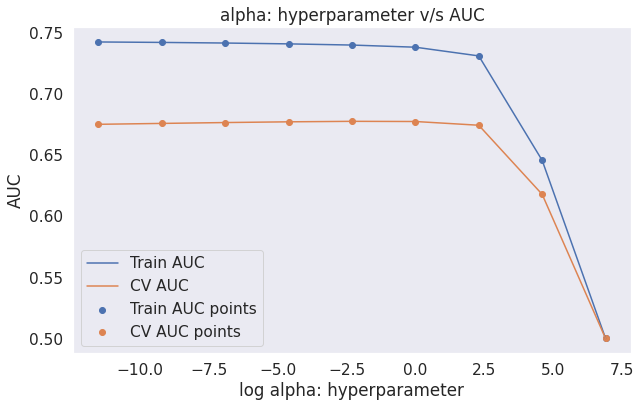

In [486]:
plt.figure(figsize=(10,6))
plt.plot(log_alphas, train_auc, label='Train AUC')
plt.plot(log_alphas, cv_auc, label='CV AUC')

plt.scatter(log_alphas, train_auc, label='Train AUC points')
plt.scatter(log_alphas, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("log alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("alpha: hyperparameter v/s AUC")
plt.grid()
plt.show()

#1.5.1.2 Testing the performance of the model on test data, plotting ROC Curves

In [487]:
bestalpha_1=clf_results.best_params_['alpha']
bestalpha_1

0.5

In [488]:
# from the error plot we choose K such that, we will have maximum AUC on cv data and gap between the train and cv is less
# Note: based on the method you use you might get different hyperparameter values as best one
# so, you choose according to the method you choose, you use gridsearch if you are having more computing power and note it will take more time
# if you increase the cv values in the GridSearchCV you will get more rebust results.

#here we are choosing the best_k based on forloop results
best_alpha =bestalpha_1

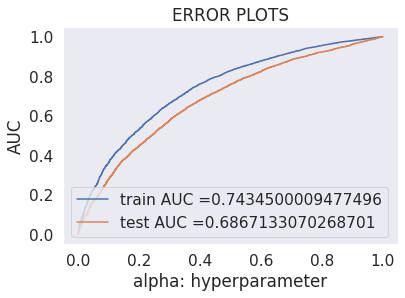

In [489]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


clf = MultinomialNB(alpha=best_alpha)

clf.fit(X_tr, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(clf, X_tr)    
y_test_pred = batch_predict(clf, X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [490]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

#confusion matrix

In [491]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.46550944672024347 for threshold 0.734
Train confusion matrix
[[ 2324  1139]
 [ 5815 13167]]
Test confusion matrix
[[1525 1021]
 [4456 9498]]


##confusion matrix

Train data confusion matrix


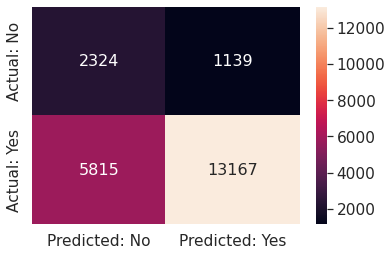

In [492]:
#plotting confusion matrix using seaborn's heatmap
# https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
import seaborn as sns; sns.set()

print("Train data confusion matrix")

confusion_matrix_df_train = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)), ['Actual: No','Actual: Yes'],['Predicted: No','Predicted: Yes'])
sns.set(font_scale=1.4)#for label size
sns.heatmap(confusion_matrix_df_train, annot=True,annot_kws={"size": 16}, fmt='g')

#1.5.4 Appling : TFIDF featurization

#set2

In [493]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr1 = hstack((X_train_essay_tfidf, X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe, X_train_price_norm,
               X_train_project_subject_categories_ohe,X_train_project_subject_subcategories_ohe,
               X_train_teacher_number_of_previously_posted_projects_norm)).tocsr()
X_cr = hstack((X_cv_essay_tfidf, X_cv_state_ohe, X_cv_teacher_ohe, X_cv_grade_ohe, X_cv_price_norm,
               X_cv_project_subject_categories_ohe,X_cv_project_subject_subcategories_ohe,
               X_cv_teacher_number_of_previously_posted_projects_norm)).tocsr()
X_te = hstack((X_test_essay_tfidf, X_test_state_ohe, X_test_teacher_ohe, X_test_grade_ohe, X_test_price_norm,
               X_test_project_subject_categories_ohe,X_test_project_subject_subcategories_ohe,
               X_test_teacher_number_of_previously_posted_projects_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(22445, 5452) (22445,)
(11055, 9588) (11055,)
(16500, 9588) (16500,)


In [494]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

In [495]:
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
import math

train_auc = []
cv_auc = []
log_alphas = []

alphas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10,  100,  1000]

for i in alphas:
    NB = MultinomialNB(alpha = i,class_prior=[0.5,0.5])
    NB.fit(X_tr1, y_train)

    y_train_pred = batch_predict(NB, X_tr1)    
    y_cv_pred = batch_predict(NB, X_cr)
    

    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

for a in tqdm(alphas):
    b = math.log(a)
    log_alphas.append(b)

100%|██████████| 9/9 [00:00<00:00, 16867.17it/s]


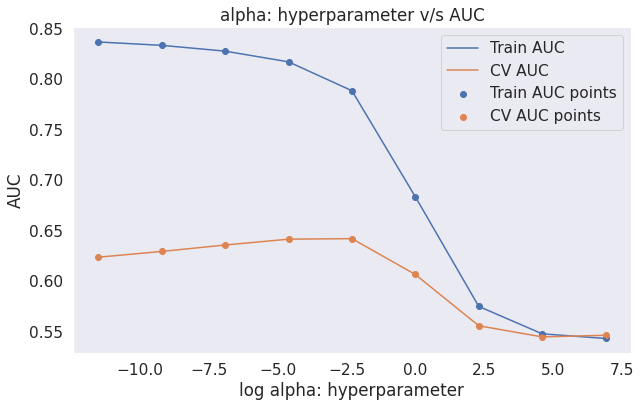

In [496]:
plt.figure(figsize=(10,6))
plt.plot(log_alphas, train_auc, label='Train AUC')
plt.plot(log_alphas, cv_auc, label='CV AUC')

plt.scatter(log_alphas, train_auc, label='Train AUC points')
plt.scatter(log_alphas, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("log alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("alpha: hyperparameter v/s AUC")
plt.grid()
plt.show()

In [497]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV

mnb_bow = MultinomialNB(class_prior=[0.5, 0.5])
parameters = {'alpha':[0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]}
clf = GridSearchCV(mnb_bow, parameters, cv=3, scoring='roc_auc',verbose=1,return_train_score=True)
clf_results=clf.fit(X_tr1, y_train)
print(clf_results.best_score_)
print(clf_results.best_estimator_)
print(clf_results.best_params_)

Fitting 3 folds for each of 14 candidates, totalling 42 fits
0.6343916995836821
MultinomialNB(alpha=0.05, class_prior=[0.5, 0.5])
{'alpha': 0.05}


100%|██████████| 14/14 [00:00<00:00, 22472.35it/s]


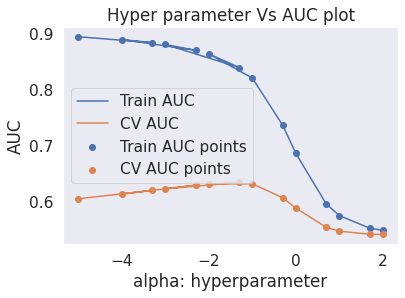

In [498]:
train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score']
cv_auc_std= clf.cv_results_['std_test_score']
alpha=[0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]
log_alpha=[]
for a in tqdm(alpha):
    b = np.log10(a)
    log_alpha.append(b)


plt.plot(log_alpha, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(log_alpha, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(log_alpha, train_auc, label='Train AUC points')
plt.scatter(log_alpha, cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

In [499]:
bestalpha_2=clf_results.best_params_['alpha']
bestalpha_2

0.05

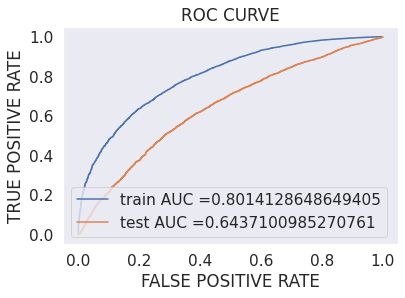

In [500]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


mnb_tfidf_testModel = MultinomialNB(alpha = bestalpha_2,class_prior=[0.5, 0.5])
mnb_tfidf_testModel.fit(X_tr1, y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = mnb_tfidf_testModel.predict_proba(X_tr1)[:,1]  
y_test_pred = mnb_tfidf_testModel.predict_proba(X_te)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FALSE POSITIVE RATE")
plt.ylabel("TRUE POSITIVE RATE")
plt.title("ROC CURVE")
plt.grid()
plt.show()

In [501]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [502]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.5180233364234329 for threshold 0.516
Train confusion matrix
[[ 2549   914]
 [ 5623 13359]]
Test confusion matrix
[[1358 1188]
 [4486 9468]]


Train data confusion matrix


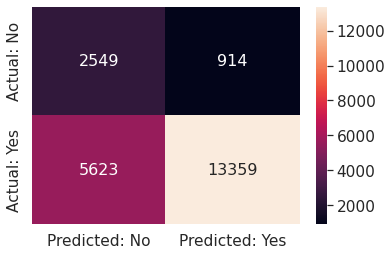

In [503]:
#plotting confusion matrix using seaborn's heatmap
# https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
import seaborn as sns; sns.set()

print("Train data confusion matrix")

confusion_matrix_df_train = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)), ['Actual: No','Actual: Yes'],['Predicted: No','Predicted: Yes'])
sns.set(font_scale=1.4)#for label size
sns.heatmap(confusion_matrix_df_train, annot=True,annot_kws={"size": 16}, fmt='g')

# imp features

In [504]:
nb_bow = MultinomialNB(alpha = 10,class_prior=[0.5,0.5])

nb_bow.fit(X_tr, y_train)

MultinomialNB(alpha=10, class_prior=[0.5, 0.5])

In [505]:
bow_features_names1 = []

In [506]:
#this code taken from https://imgur.com/mWvE7gj
all_feature_names_bow=[]
for i in vectorizer1.get_feature_names():
    all_feature_names_bow.append(i)   

for i in vectorizer2.get_feature_names():
    all_feature_names_bow.append(i)    

for i in vectorizer3.get_feature_names():
    all_feature_names_bow.append(i)    

for i in vectorizer4.get_feature_names():
    all_feature_names_bow.append(i)   

for i in vectorizer5.get_feature_names():
    all_feature_names_bow.append(i)   
   

for i in vectorizer_bow_essay.get_feature_names():
    all_feature_names_bow.append(i)   
all_feature_names_bow.append("price")
all_feature_names_bow.append("teacher_number_of_previously_posted_projects")

print( len(all_feature_names_bow))

5452


In [508]:
#for BOW
nb = MultinomialNB(alpha=0.5,class_prior=[0.5,0.5])
nb.fit(X_tr,y_train)# fit the model
# now make a dictionary of all the probabilities fo the weights
bow_features_probs = []
for a in range(len(all_feature_names_bow)):
    bow_features_probs.append(nb.feature_log_prob_[0,a] )
print(len(bow_features_probs))

5452


In [509]:
#top 20 negatives
final_bow_features = pd.DataFrame({'feature_prob_estimates' : bow_features_probs, 'feature_names': all_feature_names_bow})
a =final_bow_features.sort_values(by = ['feature_prob_estimates'], ascending = False)
a.head(20)

,feature_prob_estimates,feature_names
4257,-3.484473,that come
218,-3.638515,earlydevelopment_environmentalscience
3842,-3.752417,six
3545,-3.944513,provide my
2719,-4.195345,live in
1859,-4.277197,feel that
2504,-4.441474,is one
395,-4.534602,literature_writing_teamsports
4113,-4.598274,students to move
4003,-4.719603,students are able


In [510]:
#top 20 Positives
bow_features_probs_pos = []
for a in range(len(all_feature_names_bow)):
    bow_features_probs_pos.append(nb.feature_log_prob_[1,a] )# positive feature probabilities
#len(bow_features_probs)
final_bow_features = pd.DataFrame({'feature_prob_estimates_pos' : bow_features_probs_pos,'feature_names' : all_feature_names_bow})
a =final_bow_features.sort_values(by = ['feature_prob_estimates_pos'], ascending = False)
a.head(20)

,feature_prob_estimates_pos,feature_names
4257,-3.485547,that come
218,-3.646067,earlydevelopment_environmentalscience
3842,-3.735842,six
3545,-3.935568,provide my
2719,-4.209617,live in
1859,-4.299985,feel that
2504,-4.442132,is one
395,-4.576440,literature_writing_teamsports
4113,-4.617133,students to move
4003,-4.707031,students are able


#summary

In [513]:
# http://zetcode.com/python/prettytable/

from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Hyperparameters(ALPHA)", "Test AUC"]

x.add_row(["BOW", "Naive Bayes","(0.5)", 0.68])
x.add_row(["TFIDF", "Naive Bayes", "(0.05)",  0.64])
print(x)

+------------+-------------+------------------------+----------+
| Vectorizer |    Model    | Hyperparameters(ALPHA) | Test AUC |
+------------+-------------+------------------------+----------+
|    BOW     | Naive Bayes |         (0.5)          |   0.68   |
|   TFIDF    | Naive Bayes |         (0.05)         |   0.64   |
+------------+-------------+------------------------+----------+
